<a href="https://colab.research.google.com/github/Pulsar-kkaturi/Deepnoid-Education/blob/master/Lecture2_FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![대체 텍스트](https://raw.githubusercontent.com/deepnoid/education/master/7.%20Deep%20Learning%20Keras/dataset/deepnoid_logo.jpg)

In [ ]:
!git clone https://github.com/Pulsar-kkaturi/Deepnoid-Education.git

Cloning into 'education'...
remote: Enumerating objects: 767, done.
remote: Counting objects: 100% (767/767), done.
remote: Compressing objects: 100% (711/711), done.
remote: Total 767 (delta 55), reused 747 (delta 46), pack-reused 0
Receiving objects: 100% (767/767), 59.97 MiB | 24.80 MiB/s, done.
Resolving deltas: 100% (55/55), done.


# 모듈 불러오기

In [ ]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import keras.backend as K
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

Using TensorFlow backend.


# **경로 설정하기**

In [ ]:
BASE_PATH = r'./education/7. Deep Learning Keras/dataset/segmentation'
IMG_DATA_PATH = os.path.join(BASE_PATH, 'lung_cancer', 'input', '2d_images')
MASK_DATA_PATH = os.path.join(BASE_PATH, 'lung_cancer', 'input', '2d_masks')

In [ ]:
IMG_DATA_PATH

'./education/7. Deep Learning Keras/dataset/segmentation/lung_cancer/input/2d_images'

# **하이퍼 파라미터**
하이퍼 파라미터를 이용해 인공지능 모델을 조정합니다.  
주로 사용하는 하이퍼 파라미터는 다음과 같습니다.

In [ ]:
IMG_HEIGHT, IMG_WIDTH = (96, 96) # 이미지 사이즈
EPOCHS = 10                      # 훈련 횟수
BATCH_SIZE = 5                   # 한번에 입력할 데이터 개수 
INIT_FILTERS = 32                # 모델 채널 크기
LEARNING_RATE = 2e-4             # 학습률
DECAY_RATE = 0.9                 # 학습률 감소 비율 
ACTIVATION_FN = 'elu'            # 활성함수 ex: relu, elu, sigmoid
DROP_RATE = 0.25                 # 드롭아웃 비율
VAL_RATIO = 0.2                  # 검증 데이터 비율

# **데이터 불러오기**

이미지와 레이블 데이터를 불러옵니다.  
glob.glob 함수를 이용해 경로에 있는 파일들을 검색할 수 있습니다.

In [ ]:
img_path = sorted(glob.glob(os.path.join(IMG_DATA_PATH, '*.tif')))
mask_path = sorted(glob.glob(os.path.join(MASK_DATA_PATH, '*.tif')))

In [ ]:
img_path

['./education/7. Deep Learning Keras/dataset/segmentation/lung_cancer/input/2d_images/ID_0000_Z_0142.tif',
 './education/7. Deep Learning Keras/dataset/segmentation/lung_cancer/input/2d_images/ID_0001_Z_0146.tif',
 './education/7. Deep Learning Keras/dataset/segmentation/lung_cancer/input/2d_images/ID_0002_Z_0162.tif',
 './education/7. Deep Learning Keras/dataset/segmentation/lung_cancer/input/2d_images/ID_0003_Z_0132.tif',
 './education/7. Deep Learning Keras/dataset/segmentation/lung_cancer/input/2d_images/ID_0004_Z_0066.tif',
 './education/7. Deep Learning Keras/dataset/segmentation/lung_cancer/input/2d_images/ID_0005_Z_0066.tif',
 './education/7. Deep Learning Keras/dataset/segmentation/lung_cancer/input/2d_images/ID_0006_Z_0206.tif',
 './education/7. Deep Learning Keras/dataset/segmentation/lung_cancer/input/2d_images/ID_0007_Z_0211.tif',
 './education/7. Deep Learning Keras/dataset/segmentation/lung_cancer/input/2d_images/ID_0008_Z_0065.tif',
 './education/7. Deep Learning Keras/

In [ ]:
mask_path

['./education/7. Deep Learning Keras/dataset/segmentation/lung_cancer/input/2d_masks/ID_0000_Z_0142.tif',
 './education/7. Deep Learning Keras/dataset/segmentation/lung_cancer/input/2d_masks/ID_0001_Z_0146.tif',
 './education/7. Deep Learning Keras/dataset/segmentation/lung_cancer/input/2d_masks/ID_0002_Z_0162.tif',
 './education/7. Deep Learning Keras/dataset/segmentation/lung_cancer/input/2d_masks/ID_0003_Z_0132.tif',
 './education/7. Deep Learning Keras/dataset/segmentation/lung_cancer/input/2d_masks/ID_0004_Z_0066.tif',
 './education/7. Deep Learning Keras/dataset/segmentation/lung_cancer/input/2d_masks/ID_0005_Z_0066.tif',
 './education/7. Deep Learning Keras/dataset/segmentation/lung_cancer/input/2d_masks/ID_0006_Z_0206.tif',
 './education/7. Deep Learning Keras/dataset/segmentation/lung_cancer/input/2d_masks/ID_0007_Z_0211.tif',
 './education/7. Deep Learning Keras/dataset/segmentation/lung_cancer/input/2d_masks/ID_0008_Z_0065.tif',
 './education/7. Deep Learning Keras/dataset/s

모아놓은 파일들을 다음 함수를 이용해 불러옵니다.

In [ ]:
def load_and_resize_png1(path, img_height, img_width):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img, dsize=(img_height, img_width), interpolation=cv2.INTER_AREA)
    return img

def load_and_resize_png2(path, img_height, img_width):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32) / 255.
    img = cv2.resize(img, dsize=(img_height, img_width), interpolation=cv2.INTER_NEAREST)
    return img

def load_and_resize_nii(path, img_height, img_width):
    img = nb.load(path).get_data()
    img = np.transpose(np.squeeze(img), (1, 0))
    img = cv2.resize(img, dsize=(img_height, img_width), interpolation=cv2.INTER_AREA).astype(np.uint8)
    return img

불러온 이미지의 형태는 다음과 같이 (267, 96, 96) 입니다.  
***50*** 장의 세로 ***96***, 가로 ***96*** 의 이미지를 불러왔다는 의미입니다.

In [ ]:
imgs = np.stack([load_and_resize_png1(i_path, IMG_HEIGHT, IMG_WIDTH) for i_path in img_path])
print(imgs.shape)
masks = np.stack([load_and_resize_png2(m_path, IMG_HEIGHT, IMG_WIDTH) for m_path in mask_path])
print(masks.shape)

(50, 96, 96)
(50, 96, 96)


이미지를 직접 확인해볼까요?  

**왼쪽 이미지**는 우리가 AI 모델에 넣을 **인풋 이미지**고,  
**오른쪽 이미지**는 AI 모델을 학습시킬 때 필요한 정답, 즉 **레이블 이미지**입니다.

레이블 이미지와 같이 우리는 폐 영역을 분리해내는 AI 모델을 만들어 보겠습니다.

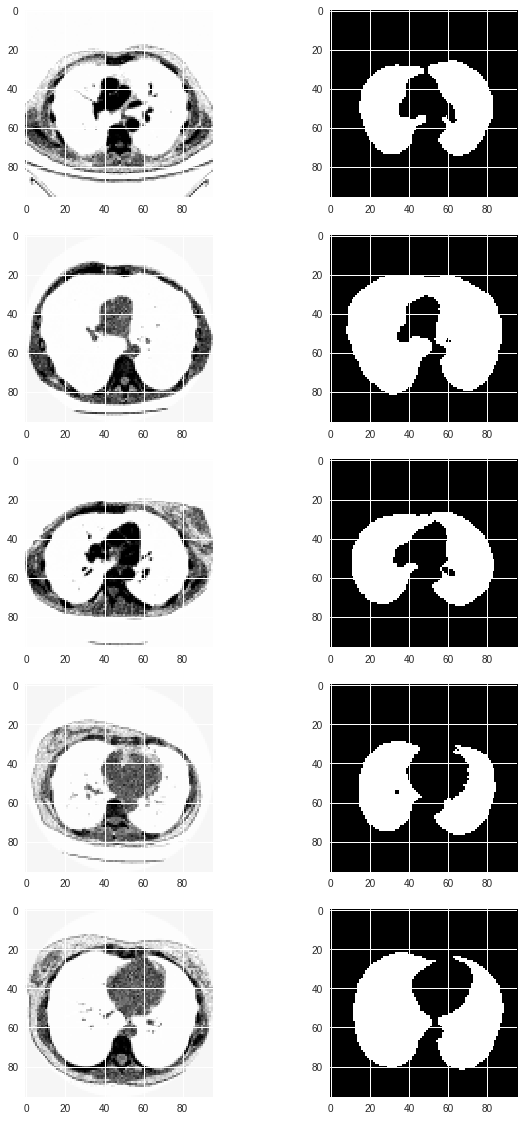

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    ax[i,0].imshow(imgs[i], cmap='gray')
    ax[i,1].imshow(masks[i], cmap='gray')
plt.show()

마스크 데이터도 살펴볼까요?

In [ ]:
masks[4, 40:60, 0:20]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0.

# **데이터 전처리**

AI 모델을 만들기 이전에 모델 학습에 도움을 줄 데이터 전처리를 살펴보겠습니다.  
이 과정을 통해 **AI 모델이 받아들이기 쉬운 형태로 데이터를 가공** 하여 학습 성능을 올릴 수 있습니다.  


먼저, 위에서 본 이미지 데이터를 컴퓨터가 실제로 인식하는 숫자 데이터로 확인해보겠습니다. 

In [ ]:
imgs[0]

array([[64716, 64733, 64725, ..., 64727, 64734, 64722],
       [64734, 64712, 64734, ..., 64726, 64714, 64729],
       [64725, 64724, 64716, ..., 64722, 64732, 64718],
       ...,
       [64714, 64721, 64726, ..., 64725, 64718, 64721],
       [64711, 64707, 64734, ..., 64741, 64721, 64722],
       [64715, 64730, 64726, ..., 64723, 64721, 64737]], dtype=uint16)

범위가 넓고 단위가 큰 숫자들을 정규화하여 학습 성능을 높여봅시다.  
가장 기본적인 정규화 방법으로 고등학교 때 배운 **Z-score** 를 사용할 수 있습니다.

In [ ]:
n_imgs = len(imgs)
imgs = np.reshape(imgs, (n_imgs, -1))
imgs_t = np.transpose(imgs, (1,0))
imgs_t_norm = (imgs_t - np.mean(imgs_t, axis=0)) / np.std(imgs_t, axis=0)
imgs = np.transpose(imgs_t_norm, (1,0))
imgs = np.reshape(imgs, (n_imgs, IMG_HEIGHT, IMG_WIDTH))

다시 값을 확인해 봅시다.

In [ ]:
imgs[0]

array([[0.59945889, 0.60033547, 0.59992296, ..., 0.60002609, 0.60038703,
        0.59976827],
       [0.60038703, 0.59925264, 0.60038703, ..., 0.59997452, 0.59935577,
        0.60012921],
       [0.59992296, 0.5998714 , 0.59945889, ..., 0.59976827, 0.6002839 ,
        0.59956202],
       ...,
       [0.59935577, 0.59971671, 0.59997452, ..., 0.59992296, 0.59956202,
        0.59971671],
       [0.59920108, 0.59899482, 0.60038703, ..., 0.60074797, 0.59971671,
        0.59976827],
       [0.59940733, 0.60018078, 0.59997452, ..., 0.59981983, 0.59971671,
        0.60054172]])

그 후 AI 모델에 넣을 수 있는 형태로 이미지 형태를 변형해 보겠습니다. 

In [ ]:
print('변경 전 형태: ', np.shape(imgs))
imgs = imgs[:,:,:,np.newaxis]
masks = masks[:,:,:,np.newaxis]
print('변경 후 형태: ', np.shape(imgs))

변경 전 형태:  (50, 96, 96)
변경 후 형태:  (50, 96, 96, 1)


마지막으로, 데이터를 학습용 데이터와 검증용 데이터로 나누어 봅시다.  
**학습용 데이터**는 실제로 **모델 학습에 사용** 되는 데이터이고,  
**검증용 데이터**는 학습에 사용하지 않고 학습이 잘 이뤄지는 지 **성능 확인하는 용도**로 사용합니다.

In [ ]:
imgs_train, imgs_val, masks_train, masks_val = train_test_split(imgs, masks, test_size=VAL_RATIO)
print('훈련 데이터 개수: ', len(imgs_train))
print('검증 데이터 개수: ', len(imgs_val))

훈련 데이터 개수:  40
검증 데이터 개수:  10


# **AI 모델을 구성하는 레이어 만들기**

AI 모델은 여러 개의 레이어를 쌓아 올려 만듭니다.  
가장 대표적인 레이어 구조인 **CONV-BN-ACT-POOL** 구조를 만들어 보겠습니다.

먼저 데이터가 들어가는 첫 번째 레이어를 만들어 봅시다.

In [ ]:
layer1 = Input(shape=imgs_train.shape[1:])

그 다음으로 데이터의 특징을 추출할 Convolution 레이어를 연결하겠습니다.

In [ ]:
layer2 = Conv2D(filters=8, kernel_size=(3, 3), activation=None, padding='same')(layer1)

Instructions for updating:
Colocations handled automatically by placer.


다음으로 레이어 중간에서 정규화를 도와줄 Batch Normalization 레이어를 추가하겠습니다.

In [ ]:
layer3 = BatchNormalization()(layer2)

Batch Normalization 이후 신호를 변환하여 다음 뉴런으로 전달하는 Activation function 레이어를 추가합니다.

In [ ]:
layer4 = Activation('relu')(layer3) #### concat용

이미지 사이즈를 줄여주는 Pooling 레이어를 연결합니다.

In [ ]:
layer5 = MaxPool2D(strides=(2, 2))(layer4)

다시 Conv-BN-ACT 레이어를 연결합니다.

In [ ]:
layer6 = Conv2D(filters=16, kernel_size=(3, 3), activation=None, padding='same')(layer5)

In [ ]:
layer7 = BatchNormalization()(layer6)

In [ ]:
layer8 = Activation('relu')(layer7)

이번에는 이미지 사이즈를 키워주는 Upsampling 레이어를 연결합니다.

In [ ]:
layer9 = UpSampling2D(size=(2, 2))(layer8) ### concat 용

레이어4와 레이어9를 함께 합쳐봅시다.

In [ ]:
layer10 = concatenate([layer9, layer4], axis=-1)

마지막으로 아웃풋 레이어를 연결합니다.

In [ ]:
layer11 = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(layer10)

지금까지 만든 레이어를 Model 함수에 넣어 연결하면 모델이 완성됩니다.

In [ ]:
sample_model = Model(layer1, layer11)
sample_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 96, 96, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 96, 96, 8)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

# 폐 영역 분리 AI 모델 만들기1

In [ ]:
input_layer = Input(shape=imgs_train.shape[1:])

filters = INIT_FILTERS
c1 = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(input_layer)
c1 = BatchNormalization()(c1)
c1 = Activation(ACTIVATION_FN)(c1)
l = MaxPool2D(strides=(2, 2))(c1)

filters *= 2
c2 = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
c2 = BatchNormalization()(c2)
c2 = Activation(ACTIVATION_FN)(c2)
l = MaxPool2D(strides=(2, 2))(c2)

filters *= 2
c3 = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
c3 = BatchNormalization()(c3)
c3 = Activation(ACTIVATION_FN)(c3)
l = MaxPool2D(strides=(2, 2))(c3)

filters *= 2
c4 = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
c4 = BatchNormalization()(c4)
c4 = Activation(ACTIVATION_FN)(c4)
l = concatenate([UpSampling2D(size=(2, 2))(c4), c3], axis=-1)

l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)
l = concatenate([UpSampling2D(size=(2, 2))(l), c2], axis=-1)

filters //= 2
l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)
l = concatenate([UpSampling2D(size=(2, 2))(l), c1], axis=-1)

filters //= 2
l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

filters //= 2
l = Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = BatchNormalization()(l)
l = Activation(ACTIVATION_FN)(l)

output_layer = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid', padding='same')(l)
    
model = Model(input_layer, output_layer)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 96, 96, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 96, 96, 32)   128         conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 96, 96, 32)   0           batch_normalization_3[0][0]      
__________________________________________________________________________________________________
max_poolin

# 폐 영역 분리 AI 모델 만들기2

In [ ]:
def conv_layer(layer, filters, activation, kernel_size=(3, 3)):
    layer = Conv2D(filters=filters, kernel_size=kernel_size, activation=None, padding='same')(layer)
    layer = BatchNormalization()(layer)
    layer = Activation(activation)(layer)
    return layer

In [ ]:
input_layer = Input(shape=imgs_train.shape[1:])

filters = INIT_FILTERS
c1 = conv_layer(layer=input_layer, filters=filters, activation=ACTIVATION_FN)
l = MaxPool2D(strides=(2, 2))(c1)

filters *= 2
c2 = conv_layer(layer=l, filters=filters, activation=ACTIVATION_FN)
l = MaxPool2D(strides=(2, 2))(c2)

filters *= 2
c3 = conv_layer(layer=l, filters=filters, activation=ACTIVATION_FN)
l = MaxPool2D(strides=(2, 2))(c3)

filters *= 2
c4 = conv_layer(layer=l, filters=filters, activation=ACTIVATION_FN)
l = concatenate([UpSampling2D(size=(2, 2))(c4), c3], axis=-1)

l = conv_layer(layer=l, filters=filters, activation=ACTIVATION_FN)
l = concatenate([UpSampling2D(size=(2, 2))(l), c2], axis=-1)

filters //= 2
l = conv_layer(layer=l, filters=filters, activation=ACTIVATION_FN)
l = concatenate([UpSampling2D(size=(2, 2))(l), c1], axis=-1)

filters //= 2
l = conv_layer(layer=l, filters=filters, activation=ACTIVATION_FN)

filters //= 2
l = conv_layer(layer=l, filters=filters, activation=ACTIVATION_FN)

output_layer = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(l)
    
model = Model(input_layer, output_layer)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 96, 96, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 96, 96, 32)   128         conv2d_13[0][0]                  
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 96, 96, 32)   0           batch_normalization_11[0][0]     
__________________________________________________________________________________________________
max_poolin

# 미리 훈련시킨 AI 모델 파일 불러오기

AI 모델을 처음부터 훈련시켜도 되지만,  
미리 훈련시킨 모델 파일이 있는 경우 불러와서 훈련시킬 수도 있습니다. 

In [ ]:
# model.load_weights('lung.h5')

# AI 모델 옵션 설정하기

AI 모델을 만든 후 여러가지 훈련 옵션을 설정할 수 있습니다.  
학습률(Learning_rate) 과 손실함수(Loss function), 정확도 기준(Dice_score) 등을 설정해 봅시다.

먼저 정확도 기준으로 Dice score 를 살펴봅시다.  

In [ ]:
 def dice_score(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

옵션은 complie 을 통해 설정할 수 있습니다.  
모델의 값을 학습시키는 **Optimizer** 는 **Adam** 을 사용하고,  
정답 레이블과 예측값 사이의 차이를 계산하는 **손실 함수**는 **Cross entropy** 를 사용했습니다.   
마지막으로 **정확도 판단 기준**으로는 위에서 만든 **Dice score** 를 사용합니다. 

In [ ]:
model.compile(optimizer=Adam(LEARNING_RATE), loss='binary_crossentropy', metrics=[dice_score])

추가적으로 AI 모델 훈련 파일을 lung.h5 라는 파일로 저장해 다음에 사용할 수 있도록 했고,  
학습이 진행될 수록 학습률(Learning_rate)를 감소시켜 세밀한 조정이 가능하게 했습니다.

In [ ]:
weight_saver = ModelCheckpoint('lung.h5', monitor='val_dice_score', save_best_only=True, save_weights_only=True)
decayed_lr = LearningRateScheduler(lambda x: LEARNING_RATE * DECAY_RATE ** x)

# AI 모델 훈련하기

이렇게 준비한 AI 모델을 fit 함수를 이용해 훈련시킬 수 있습니다. 

In [ ]:
history = model.fit(imgs_train, masks_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(imgs_val, masks_val),
                    shuffle=True,
                    verbose=2,
                    callbacks=[weight_saver, decayed_lr])

Instructions for updating:
Use tf.cast instead.
Train on 40 samples, validate on 10 samples
Epoch 1/10
 - 23s - loss: 0.3674 - dice_score: 0.6284 - val_loss: 0.7056 - val_dice_score: 0.5868
Epoch 2/10
 - 20s - loss: 0.1578 - dice_score: 0.7905 - val_loss: 0.8078 - val_dice_score: 0.5869
Epoch 3/10
 - 20s - loss: 0.1151 - dice_score: 0.8331 - val_loss: 0.6649 - val_dice_score: 0.6192
Epoch 4/10
 - 21s - loss: 0.1016 - dice_score: 0.8490 - val_loss: 0.3867 - val_dice_score: 0.6926
Epoch 5/10
 - 20s - loss: 0.0891 - dice_score: 0.8640 - val_loss: 0.2992 - val_dice_score: 0.7322
Epoch 6/10
 - 21s - loss: 0.0837 - dice_score: 0.8697 - val_loss: 0.2255 - val_dice_score: 0.7755
Epoch 7/10
 - 21s - loss: 0.0781 - dice_score: 0.8774 - val_loss: 0.1561 - val_dice_score: 0.8120
Epoch 8/10
 - 21s - loss: 0.0746 - dice_score: 0.8820 - val_loss: 0.1367 - val_dice_score: 0.8288
Epoch 9/10
 - 21s - loss: 0.0717 - dice_score: 0.8861 - val_loss: 0.1148 - val_dice_score: 0.8408
Epoch 10/10
 - 21s - loss:

# 훈련 결과 확인하기

훈련 결과를 한 눈에 확인할 수 있는 그래프를 만들어 보겠습니다.

먼저 그래프의 y축에 사용할 값들을 history 항목에서 추출해 봅시다.

In [ ]:
dice_score = history.history['dice_score']
val_dice_score = history.history['val_dice_score']
loss = history.history['loss']
val_loss = history.history['val_loss']

다음으로 그래프의 x축 값으로 사용할 epoch 을 뽑아 보겠습니다.

In [ ]:
epochs = range(len(dice_score))

각 값들을 확인해볼까요?

In [ ]:
dice_score

[0.6283981464803219,
 0.7905315607786179,
 0.8331497982144356,
 0.8489566966891289,
 0.8639974892139435,
 0.869667075574398,
 0.8774270936846733,
 0.881981611251831,
 0.8860706835985184,
 0.8845194429159164]

In [ ]:
val_dice_score

[0.5868233740329742,
 0.5868954062461853,
 0.619179904460907,
 0.6926271021366119,
 0.7321522533893585,
 0.7754786610603333,
 0.812027096748352,
 0.8288067281246185,
 0.840800553560257,
 0.8498924970626831]

In [ ]:
loss

[0.3674407098442316,
 0.1578244175761938,
 0.11512019112706184,
 0.10159869492053986,
 0.08910705521702766,
 0.08366991300135851,
 0.07809044793248177,
 0.0745974974706769,
 0.0716679091565311,
 0.071509073022753]

In [ ]:
val_loss

[0.7056059539318085,
 0.8077757358551025,
 0.6649119555950165,
 0.3866913914680481,
 0.2991515100002289,
 0.2255396842956543,
 0.15608109533786774,
 0.1366519331932068,
 0.1148415207862854,
 0.11218171566724777]

In [ ]:
list(epochs)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

이 값들을 이용해 그래프를 만들어 보겠습니다.  

먼저 정확도 그래프를 그려볼까요?

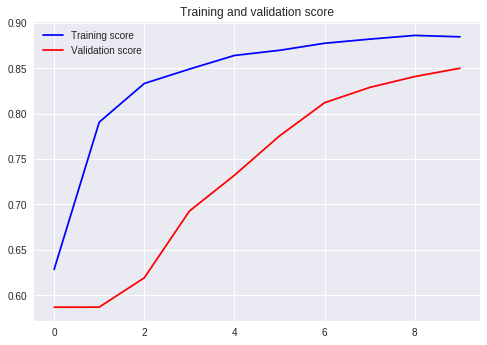

In [ ]:
plt.plot(epochs, dice_score, 'b', color='blue', label='Training score')
plt.plot(epochs, val_dice_score, 'b', color='red', label='Validation score')
plt.title('Training and validation score')
plt.legend()
plt.show()

다음으로 손실 그래프를 살펴보겠습니다.

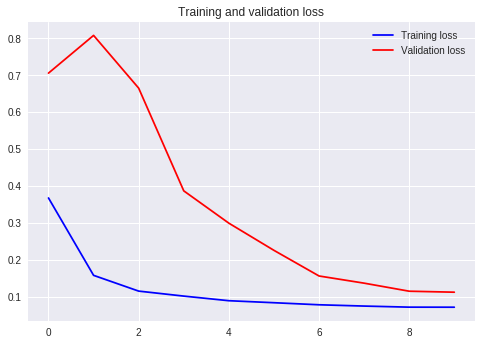

In [ ]:
plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 이미지로 결과 확인하기

마지막으로 AI 모델이 실제로 폐 영역을 잘 분리하는지 이미지로 결과를 확인해 보겠습니다. 

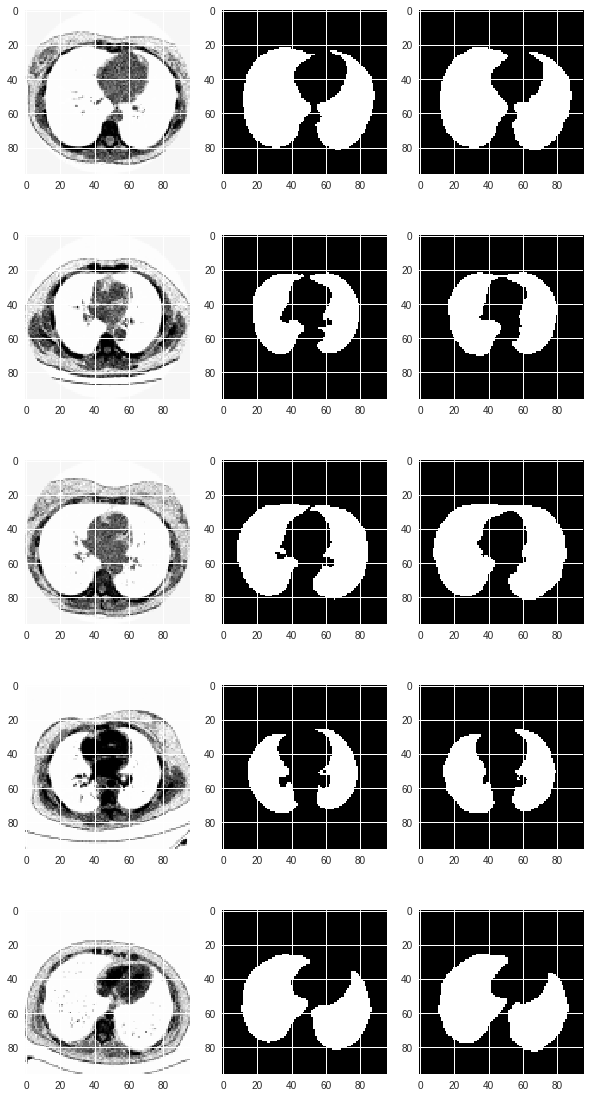

In [ ]:
fix, ax = plt.subplots(5, 3, figsize=(10,20))
for i in range(5):
    pred = model.predict(imgs_train[i][np.newaxis, :, : ,:])
    mask = (pred >= 0.5).astype(np.uint8)
    ax[i, 0].imshow(imgs_train[i, :, :, 0], cmap='gray')
    ax[i, 1].imshow(masks_train[i, :, :, 0], cmap='gray')
    ax[i, 2].imshow(mask[0, :, :, 0], cmap='gray')
plt.show()